# Signal Details

This notebook was based on a copy of the `decoder` notebook, now focused on getting the details I need about the signals to reproduce them with my own transmitter.

# Decoding
Below follows a shortened version of the `decoder` notebook:

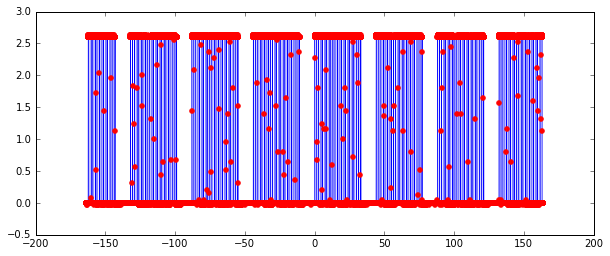

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csv = np.genfromtxt('data/a1on.csv', delimiter=',', skip_header=2, usecols=(0, 1))
csv = np.transpose(csv)
time = csv[0] * 1000  # time in ms
voltage = csv[1]

def oscilloscope(x, y, width=10, height=4, start=0, stop=None, linewidth=0.5):
    fig = plt.figure(figsize=(width, height))
    axes = fig.add_subplot(111)
    axes.plot(x[start:stop], y[start:stop], marker='o', mec='red', mfc='red', markersize=5, linewidth=linewidth)
    plt.show()

oscilloscope(time, voltage)

In [153]:
digital_one = np.percentile(voltage, 90)
digital_stream = voltage / digital_one
digital_stream = digital_stream.round().astype(int)

In [154]:
start = 43
stop = 80
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
start_index = time.tolist().index(find_nearest(time, start))
stop_index = time.tolist().index(find_nearest(time, stop))

#oscilloscope(time, digital_stream, height=3, start=start_index, stop=stop_index, width=20, linewidth=3)

In [155]:
number_of_data_points = len(digital_stream)
first_capture_time = time[0]
last_capture_time = time[-1]
total_capture_duration = last_capture_time - first_capture_time

single_data_point_duration = total_capture_duration / (number_of_data_points - 1) * 1000

In [156]:
from collections import namedtuple

Signal = namedtuple('Signal', ['high', 'duration'])
HIGH = 1

signals = []

first = True
previous = None
duration = None
last_index = len(digital_stream) - 1
for i, x in enumerate(digital_stream):
    if first:
        first = False
        previous = x
        duration = 1
        continue;

    if i == last_index or x != previous:
        high = previous == HIGH
        s = Signal(high=high, duration=duration)
        signals.append(s)
        
        previous = x
        duration = 1
    else:
        duration += 1

In [157]:
signal_pairs = []
first = None
for index, s in enumerate(signals):
    if index == 0 and s.high != True:
        # If the data begins with a low signal, drop it.
        continue;
    
    if first == None:
        first = s
    else:
        signal_pairs.append((first, s))
        first = None

#print pd.DataFrame(data=signal_pairs)

In [158]:
pair_durations = [pair[0].duration + pair[1].duration for pair in signal_pairs]
#print pair_durations

In [159]:
counts, values = np.histogram(pair_durations)

def print_table(data, columns):
    print pd.DataFrame(data=data, columns=columns)

#print_table(zip(counts, values), ['count', 'bucket'])

In [160]:
#plt.hist(pair_durations)
#plt.show()

In [161]:
from collections import Counter
c = Counter(pair_durations)
#print c
signal_pair_duration = c.most_common()[0][0]
#print signal_pair_duration

In [162]:
separator_limit = signal_pair_duration * 2

pauses = []
messages = []
message = []
last_pair_index = len(signal_pairs) - 1
for i, sp in enumerate(signal_pairs):

    # Detect separating signal
    high, low = sp
    is_separating_signal = low.duration > separator_limit
    
    # Normalize separating signals:
    # The signal that is closes to the most common signal pair duration is the reliable one of the pair.
    distance_to_high = abs(signal_pair_duration - high.duration)
    distance_to_low = abs(signal_pair_duration - low.duration)
    if distance_to_high < distance_to_low:
        # Save the duration to be discarded for later use when
        # figuring out the pause between messages:
        original_low_duration = low.duration
        
        # The high signal is the reliable one
        new_low = low._replace(duration=signal_pair_duration - high.duration)
        message.append((high, new_low))

    else:
        # The low signal is the reliable one
        new_high = high._replace(duration=signal_pair_duration - low.duration)
        message.append((new_high, low))

    if i == last_pair_index or is_separating_signal:
        messages.append(message)
        message = []
        
        # Calculate and put aside the pause between messages
        pause = original_low_duration - new_low.duration
        pauses.append(pause)

#print len(messages)
#messages

print pauses
print 'Standard deviation before removing last signal =', np.std(pauses)
# The last pause could be an ordinary low signal, let's remove it
assert len(pauses) > 2, "we have captured enough pauses"
pauses = pauses[0:-1]
print 'Standard deviation after =', np.std(pauses)
assert np.std(pauses) < 1, "pauses are roughly the same length"
print pauses

[481, 481, 481, 481, 481, 482, 482, 3]
Standard deviation before removing last signal = 158.178696416
Standard deviation after = 0.451753951453
[481, 481, 481, 481, 481, 482, 482]


In [163]:
from itertools import chain

bit_messages = []
for message in messages:
    bit_message = []
    for high, low in message:
        bit = high.duration > low.duration
        bit_message.append(bit)
    bit_messages.append(bit_message)

In [164]:
for m in bit_messages:
    msg = ''
    for b in m:
        msg += '1' if b else '0'
    print msg

010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
00010101000101010101011


# Calculating Signal Details
Now that we have all data at our fingertips, let's summarize the details we need to know to be able to reproduce the RF signal:

### Data Point Duration
Each captured data point in the input CSV has a duration in seconds, we use this to calculate the rest of the durations

In [165]:
print single_data_point_duration, 'ns'

20.0 ns


### Bit Rate

In [166]:
all_clean_signals = list(chain(*messages))
data_points_per_bit = np.median([high.duration + low.duration for high, low in all_clean_signals])
bit_rate = single_data_point_duration * data_points_per_bit
print bit_rate, 'ns'

1380.0 ns


### Message Interval
For timing each repeatedly sent message

In [167]:
assert len(pauses) > 2, "we have captured 'enough' pauses"
pause_duration = np.median(pauses) * single_data_point_duration
print 'Pause duration:', '\t', pause_duration, 'ns'

# First and last message are removed, they could be partial
message_lengths = map(len, bit_messages)
assert len(message_lengths) > 2, "we have something left after removing first and last"
whole_message_lengths = message_lengths[1:-1]
assert whole_message_lengths > 1, "more than one whole message has been captured"
assert np.std(whole_message_lengths) == 0, "all whole messages have the same length"
bits_per_message = whole_message_lengths[0]
print "Bits per message:", '\t', bits_per_message

print
message_interval = bits_per_message * bit_rate + pause_duration
print 'Message interval:', '\t', message_interval, 'ns'

Pause duration: 	9620.0 ns
Bits per message: 	25

Message interval: 	44120.0 ns


### Digital One Duration

In [168]:
high_durations = [high.duration for high, _ in chain(*messages)]
print "All high durations:"
print high_durations

print
max_high_duration = max(high_durations)
min_high_duration = min(high_durations)
print 'max:', max_high_duration
print 'min:', min_high_duration

def close_to(value, compare_to):
    return np.std([value, compare_to, compare_to]) < 1

# Let's divide them into the values close to each other
short_durations = []
long_durations = []
for d in high_durations:
    if close_to(d, min_high_duration):
        short_durations.append(d)
    elif close_to(d, max_high_duration):
        long_durations.append(d)
    else:
        raise Exception('expected all values to be close to either min or max')
print
assert len(short_durations) + len(long_durations) == len(high_durations)
assert len(short_durations) > 1

assert np.std(long_durations) < 1
digital_one_duration = np.average(long_durations) * single_data_point_duration
print "Digital one duration:", digital_one_duration, 'ns'

All high durations:
[14, 48, 14, 48, 14, 49, 14, 48, 15, 49, 14, 48, 49, 49, 13, 14, 14, 14, 49, 14, 48, 14, 48, 14, 14, 15, 49, 14, 49, 14, 48, 14, 48, 14, 48, 14, 48, 49, 48, 14, 15, 14, 14, 48, 15, 49, 14, 48, 14, 15, 14, 49, 14, 48, 15, 49, 14, 48, 15, 49, 14, 49, 48, 48, 14, 14, 15, 15, 49, 14, 49, 15, 49, 14, 14, 14, 48, 14, 48, 14, 48, 15, 49, 14, 49, 14, 48, 48, 49, 14, 14, 14, 14, 48, 14, 48, 14, 49, 14, 14, 15, 49, 14, 49, 14, 48, 14, 48, 14, 48, 15, 49, 49, 48, 14, 14, 14, 14, 48, 15, 49, 14, 48, 14, 15, 14, 49, 14, 48, 14, 49, 14, 48, 15, 49, 14, 48, 48, 48, 14, 14, 14, 15, 49, 14, 48, 15, 49, 14, 14, 14, 48, 15, 49, 14, 48, 14, 48, 14, 49, 14, 48, 48, 49, 14, 14, 14, 14, 48, 14, 48, 14, 49, 14, 15, 15, 49, 14, 48, 15, 49, 14, 49, 14, 48, 15, 49, 48]

max: 49
min: 13

Digital one duration: 969.047619048 ns


### Digital Zero Duration

In [169]:
assert np.std(short_durations) < 1
digital_zero_duration = np.average(short_durations) * single_data_point_duration
print "Digital zero duration:", digital_zero_duration, 'ns'

Digital zero duration: 284.230769231 ns
